# Song Year Prediction

### Importing all the libraries

In [1]:
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt


from tensorflow import keras
from sklearn.utils import shuffle

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split

Function to read the data from CSV File and Reading data from the mentioned file

In [2]:
def readData(filePath:str="./YearPredictionMSD.txt.csv"):
    with open(filePath) as fp:
        data = fp.readlines()
        data = list(map(lambda row: np.asarray(list(map(float,row.split(",")))),data))
    
    return np.asarray(data)

In [3]:
data = readData()

In [4]:
data[0,]

array([ 2.0010000e+03,  4.9943570e+01,  2.1471140e+01,  7.3077500e+01,
        8.7486100e+00, -1.7406280e+01, -1.3099050e+01, -2.5012020e+01,
       -1.2232570e+01,  7.8308900e+00, -2.4678300e+00,  3.3213600e+00,
       -2.3152100e+00,  1.0205560e+01,  6.1110913e+02,  9.5108960e+02,
        6.9811428e+02,  4.0898485e+02,  3.8370912e+02,  3.2651512e+02,
        2.3811327e+02,  2.5142414e+02,  1.8717351e+02,  1.0042652e+02,
        1.7919498e+02, -8.4155800e+00, -3.1787038e+02,  9.5862660e+01,
        4.8102590e+01, -9.5663030e+01, -1.8062150e+01,  1.9698400e+00,
        3.4424380e+01,  1.1726700e+01,  1.3679000e+00,  7.7944400e+00,
       -3.6994000e-01, -1.3367852e+02, -8.3261650e+01, -3.7297650e+01,
        7.3046670e+01, -3.7366840e+01, -3.1385300e+00, -2.4215310e+01,
       -1.3230660e+01,  1.5938090e+01, -1.8604780e+01,  8.2154790e+01,
        2.4057980e+02, -1.0294070e+01,  3.1584310e+01, -2.5381870e+01,
       -3.9077200e+00,  1.3292580e+01,  4.1550600e+01, -7.2627200e+00,
      

## Plotting the distribution of the labels in the original dataset

<AxesSubplot: ylabel='Count'>

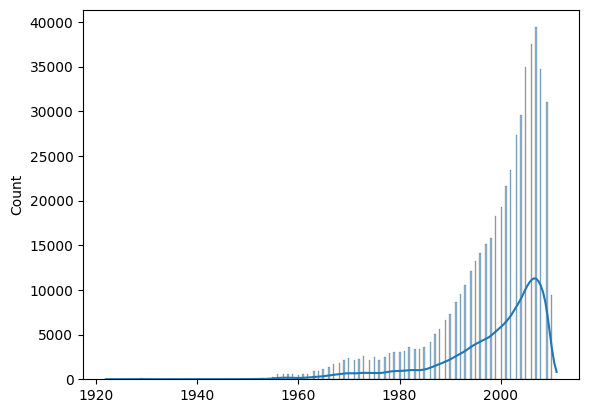

In [5]:
sns.histplot(data=data[:,0], kde=True)

### Removing noise and outliers from the dataset.
##### Removing all the records that are minor

In [6]:
new_data = data
for i in range(1920,2017):
    idx = np.where(new_data[:,0] == float(i))[0]
    if idx.size and idx.size < 100:
        new_data = np.delete(new_data,idx,axis=0)
    

## Plotting the distribution of class after removing the outliers

<AxesSubplot: ylabel='Count'>

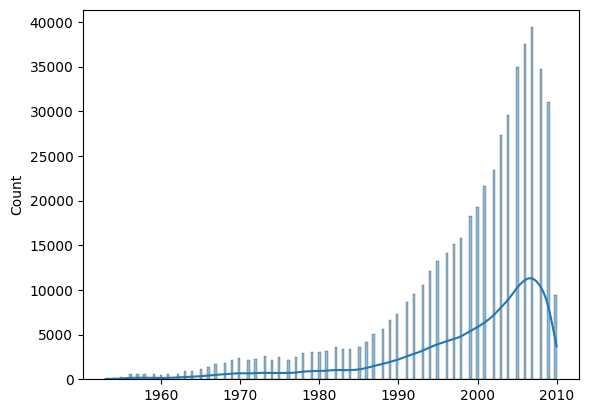

In [7]:
sns.histplot(data=new_data[:,0], kde=True)

## Relabeling the feature

In [8]:
labels = list(set(new_data[:,0].tolist()))

for i in range(len(labels)):
    idx = np.where(new_data[:,0] == labels[i])[0]
    np.put(new_data[:,0],idx,i)


## Visualing the data before dimensionality reduction

In [ ]:
figure, axis = plt.subplots(23,23)
figure.set_figwidth(100)
figure.set_figheight(100)
for i in range(23):
    for j in range(23):
        axis[i,j].scatter(new_data[:, i], new_data[:, j], alpha=0.2)

## Feature Selection || Feature Elimination

This values of column were selected on the basis of visualization (above is partial visualization of the dataset) and along with it trial and error method was used to finally select columns. After many iteration of training model, this values were dropped off.

Initially to select features one by one feature was included in trianing and performance was obeserved. After that the feature which didn;t increased were dropped off.

Below are those features. There were other features which didn;t increased performance by great margin but they dealt by PCA | Dimensionality Reduction.

In [9]:
removeFeatures = [23, 44, 45, 56, 57, 66, 70, 80]
new_data = np.delete(new_data,removeFeatures,axis=1)

## Splitting the data into training and test dataset

<AxesSubplot: ylabel='Count'>

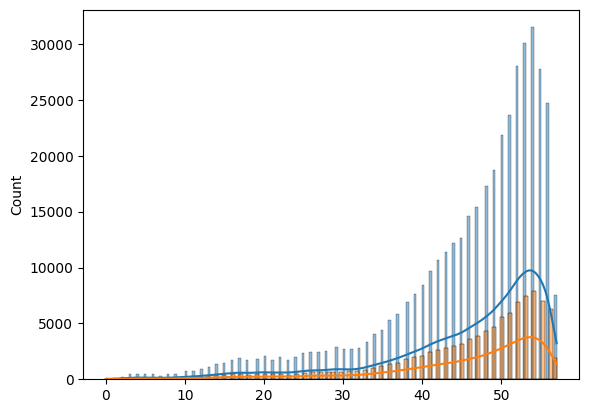

In [10]:
train_data,test_data,train_label,test_label = train_test_split(new_data[:,1:],new_data[:,0],test_size=0.2)
sns.histplot(data=train_label, kde=True)
sns.histplot(data=test_label, kde=True)

## Preprocessing and oversampling the data to tackle againt data imbalance

In [11]:
def upSampleData(train_data,train_label,labels,min_sample = 10000,upSample = 10000):
    freq_cnt = [0]*(len(labels)+1)
    for val in train_label:
        freq_cnt[int(val)] += 1

    edata,fg1,elbl = None,False,None
    for i in range(len(labels)+1):
        if freq_cnt[i] and freq_cnt[i] < min_sample:
            fct = upSample//freq_cnt[i]
            idx = np.where(i == train_label)[0]
            ndata = np.tile(np.take(train_data,idx,axis=0),(fct,1))
            lbl_tmp = np.asarray([i]*fct*freq_cnt[i])
            if not fg1:
                fg1 = True
                edata = ndata
                elbl = lbl_tmp
                continue
            edata = np.concatenate([edata,ndata])
            elbl = np.concatenate([elbl,lbl_tmp])

    return edata,np.concatenate([train_label,elbl])


def preProcessData(train_data,ex_data,test_data):
    pca = PCA(0.95)
    st = StandardScaler()
    st.fit(train_data)
    pca.fit(train_data)
    
    data = np.concatenate([train_data,ex_data])
    
    data = st.transform(data)
    data = pca.transform(data)   
    #data = normalize(data)
    test_data = st.transform(test_data)
    test_data = pca.transform(test_data)

    data = st.fit_transform(data)
    test_data = st.transform(test_data)
    print("New Dimensionality",data.shape)
    return data,test_data

    
def convertToOneHot(train_label,test_label,labels):
    train_label = train_label.astype(int)
    test_label = test_label.astype(int)
    t1l = np.zeros((train_label.size,len(labels)+1))
    t1l[np.arange(train_label.size),train_label] = 1

    t2l = np.zeros((test_label.size,len(labels)+1))
    t2l[np.arange(test_label.size),test_label] = 1
    return t1l,t2l
    
exData,train_label = upSampleData(train_data,train_label,labels)
train_data,test_data = preProcessData(train_data,exData,test_data)
train_label,test_label = convertToOneHot(train_label,test_label,labels)

New Dimensionality (792296, 20)


## Visualizing the data after dimensionality reduction

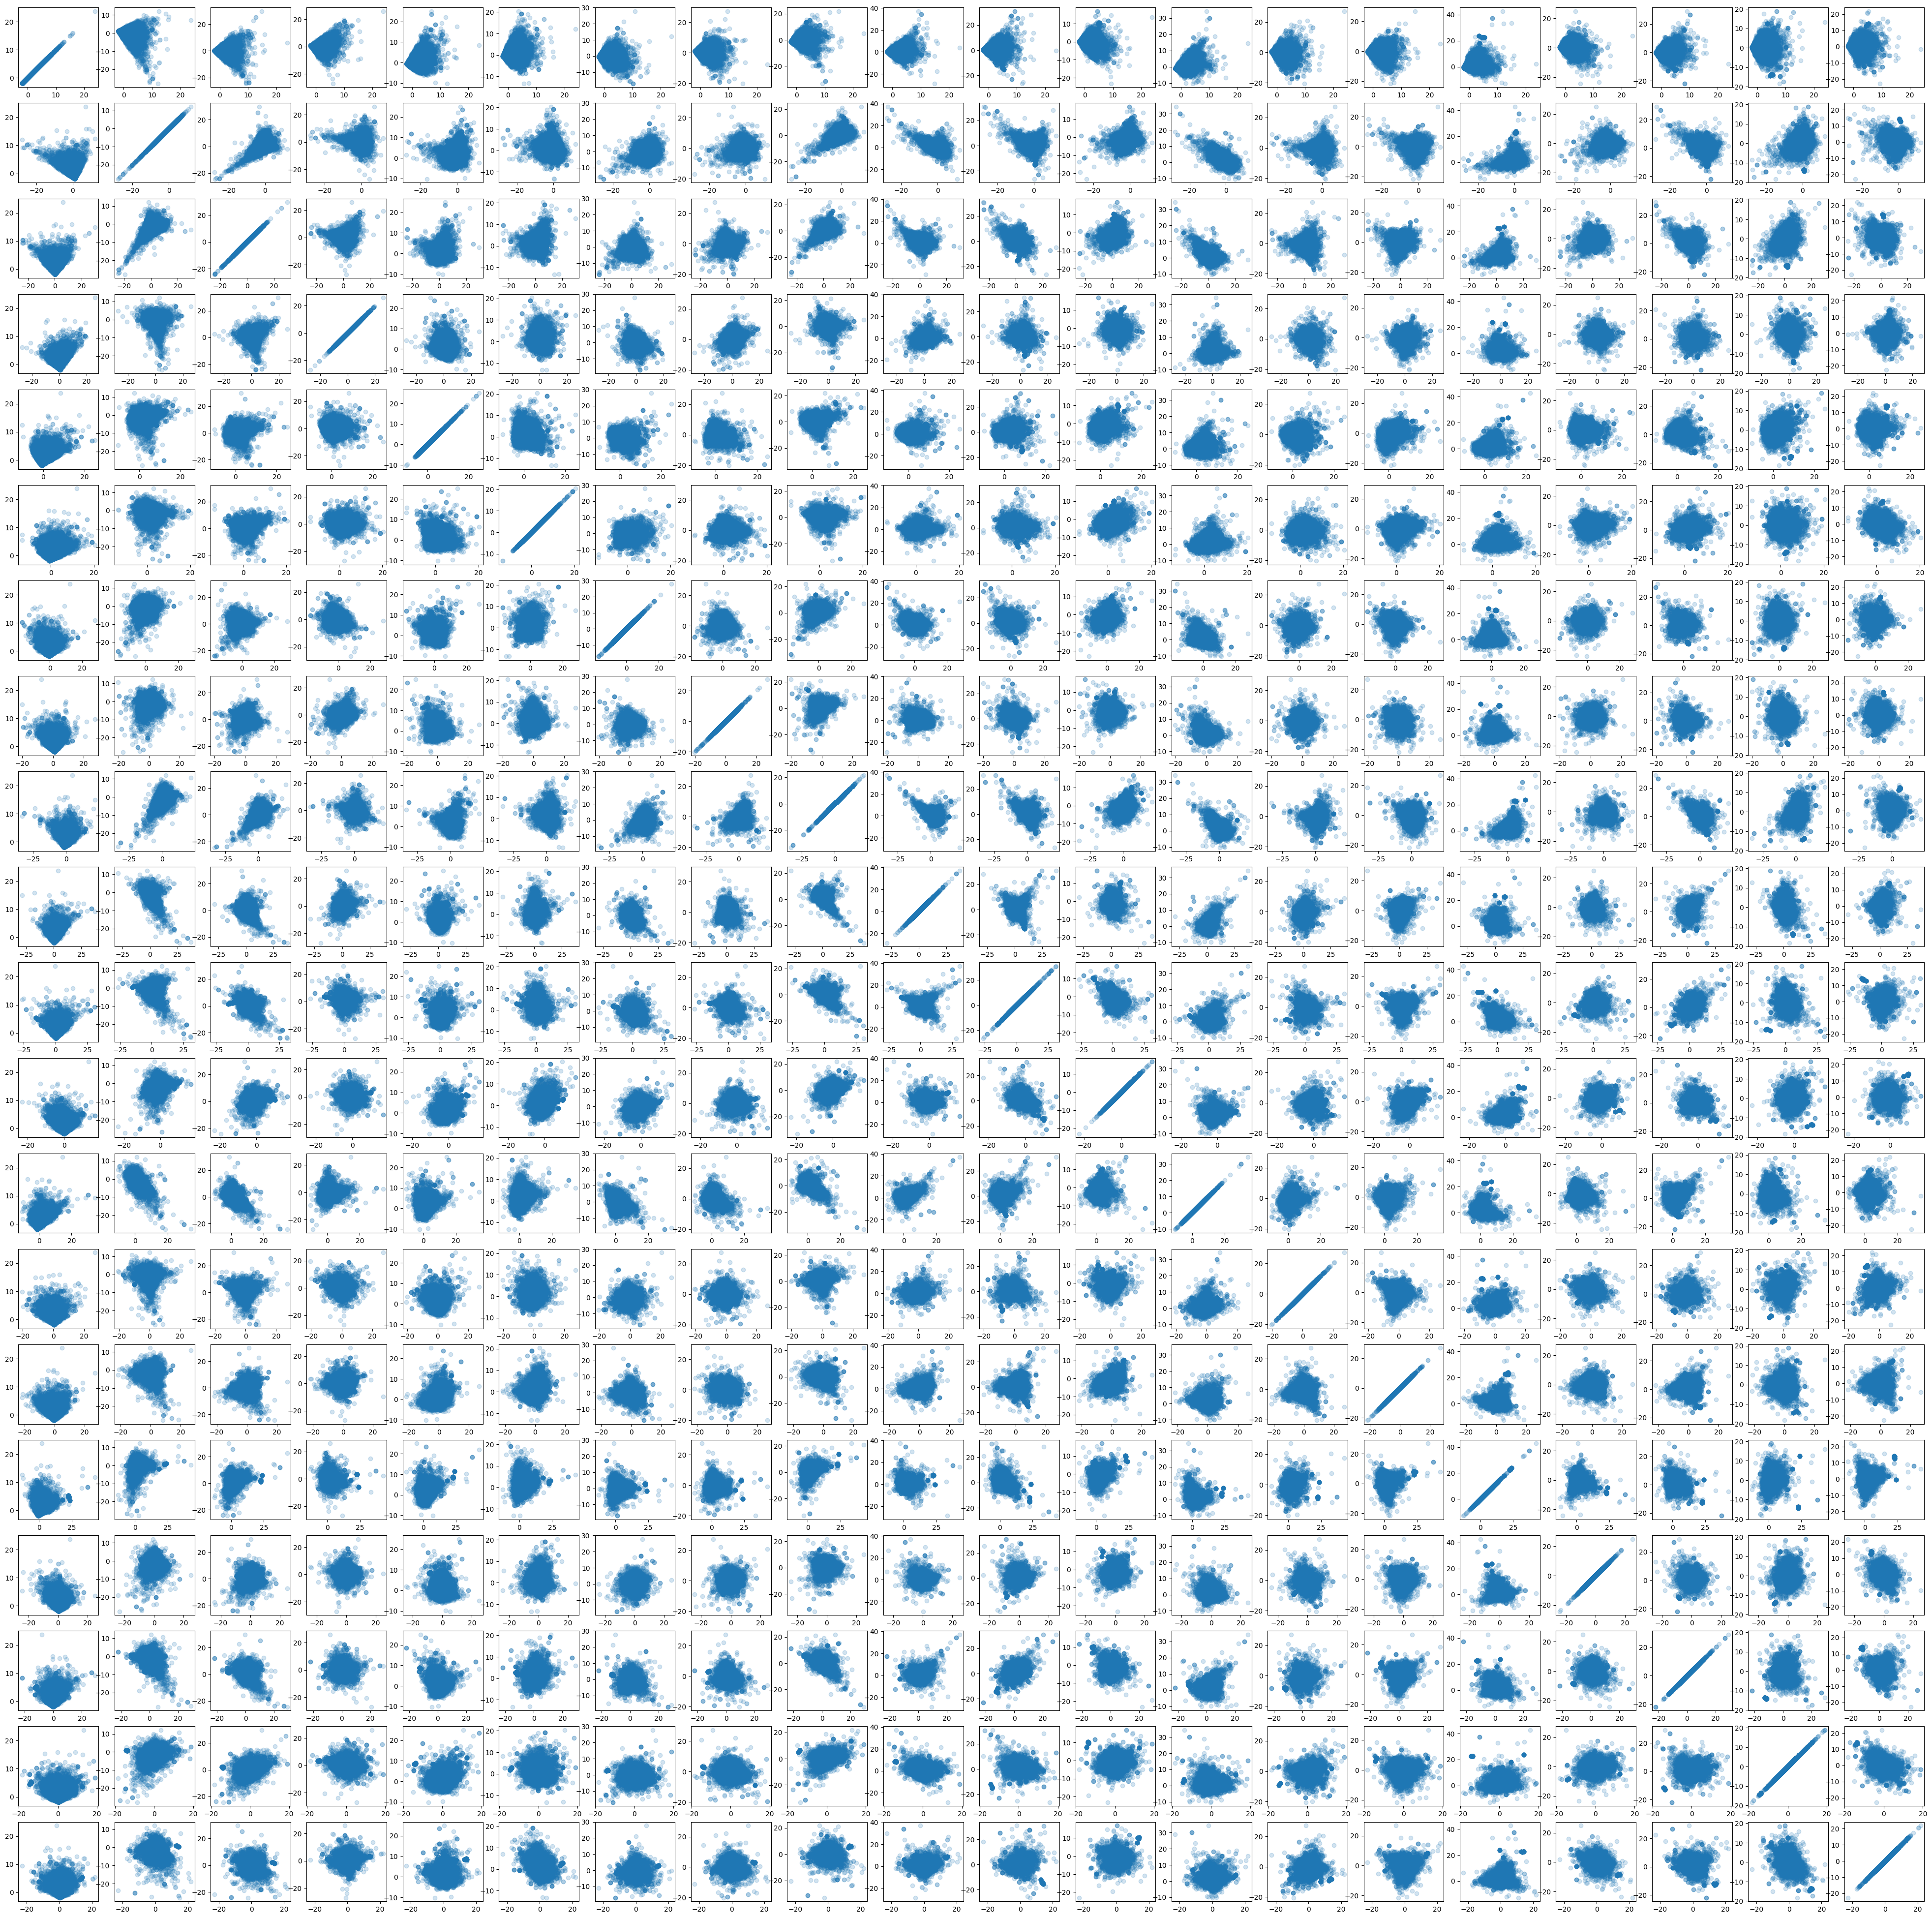

In [33]:
figure, axis = plt.subplots(20,20)
figure.set_figwidth(50)
figure.set_figheight(50)
for i in range(20):
    for j in range(20):
        axis[i,j].scatter(train_data[:, i], train_data[:, j], alpha=0.2)

## Visualizing the features and class

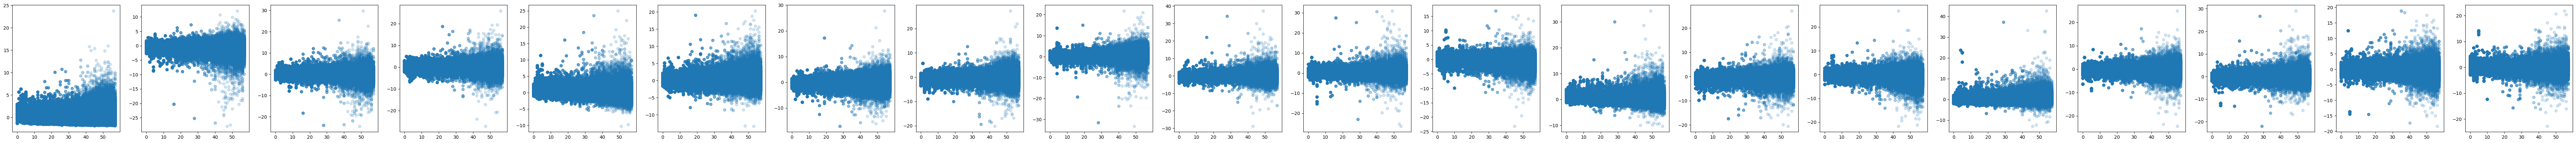

In [13]:
figure, axis = plt.subplots(1,20)
figure.set_figwidth(100)
figure.set_figheight(5)
lbls = np.argmax(train_label,axis=1)
for i in range(20):
    axis[i].scatter(lbls,train_data[:, i], alpha=0.2)

## Neural Network 

In [23]:
class SongClassifier(keras.Model):
    def __init__(self, input_dim, num_classes=100, *args, **kwargs):
        super(SongClassifier, self).__init__(name="SongClassifier", *args, **kwargs)
        self.DenseL1 = [keras.layers.Dense(1024,activation = keras.activations.relu,input_shape=input_dim) for _ in range(15)]
        self.NoiseLayer = keras.layers.GaussianNoise(stddev=1e-3)
        self.DenseL2 = [keras.layers.Dense(512,activation = keras.activations.relu) for _ in range(15)]
        self.DenseL3 = [keras.layers.Dense(128, activation = keras.activations.relu) for _ in range(15)]
        self.AVLayer = keras.layers.Average()
        self.OutL = keras.layers.Dense(num_classes,activation = tf.nn.softmax)

    def call(self, data, training = False):
        l1_out = [l1(data) for l1 in self.DenseL1]
        l1_out = [self.NoiseLayer(l1,training=training) for l1 in l1_out]
        l2_out = [(l2(l1)) for l1, l2 in zip(l1_out, self.DenseL2)]
        l3_out = self.AVLayer([l3(l2) for l2, l3 in zip(l2_out, self.DenseL3)])
        l_out = self.OutL(l3_out)
        return l_out


def get_IModel(input_shape, output_shape, decay_steps=1000000, pwr: float = 0.95, starter_learning_rate: float = 1e-2, end_learning_rate: float = 1e-6):
    model = SongClassifier(input_shape, output_shape)

    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(starter_learning_rate, decay_steps, end_learning_rate, power=pwr)
    
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate_fn, clipnorm=1.0, epsilon=1e-09),
                  loss=keras.losses.categorical_crossentropy,
                  metrics=[
        keras.metrics.Recall(),
        keras.metrics.Precision()
    ])
    return model

model = get_IModel((train_data.shape[1],),len(labels)+1)
model.load_weights("ModelWei_1")


### Training the neural network

In [19]:
out = []
for _ in range(25):
    train_data,train_label = shuffle(train_data,train_label)
    tr_data,val_data,tr_label,val_label = train_test_split(train_data,train_label,test_size=0.2,random_state=42)
    h = model.fit(tr_data,tr_label,validation_data=(val_data,val_label),epochs=10,batch_size=4096)
    out.append(h)

Epoch 1/10


2022-11-30 21:28:50.902090: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - ETA: 0s - loss: 3.6322 - recall_1: 0.0169 - precision_1: 0.8656

2022-11-30 21:29:17.495754: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


155/155 [==============================] - 32s 161ms/step - loss: 3.6322 - recall_1: 0.0169 - precision_1: 0.8656 - val_loss: 3.4083 - val_recall_1: 0.0456 - val_precision_1: 0.8643
Epoch 2/10
155/155 [==============================] - 19s 125ms/step - loss: 3.2307 - recall_1: 0.0796 - precision_1: 0.9140 - val_loss: 3.0916 - val_recall_1: 0.1063 - val_precision_1: 0.9322
Epoch 3/10
155/155 [==============================] - 19s 124ms/step - loss: 2.9623 - recall_1: 0.1353 - precision_1: 0.9358 - val_loss: 2.8948 - val_recall_1: 0.1512 - val_precision_1: 0.9265
Epoch 4/10
155/155 [==============================] - 19s 125ms/step - loss: 2.7745 - recall_1: 0.1683 - precision_1: 0.9370 - val_loss: 2.7410 - val_recall_1: 0.1800 - val_precision_1: 0.9300
Epoch 5/10
155/155 [==============================] - 19s 125ms/step - loss: 2.6174 - recall_1: 0.1991 - precision_1: 0.9254 - val_loss: 2.6137 - val_recall_1: 0.2040 - val_precision_1: 0.9202
Epoch 6/10
155/155 [==========================

## Evaluating the model on unseen test data

In [30]:
prd = model.predict(test_data,batch_size = 4096)
cnt = 0
for x,y in zip(test_label,prd):
    x,y = np.argmax(x),np.argmax(y)
    if x == y:
        continue
    cnt += 1
print("Total number of samples",test_label.shape[0],"Total number of incorretly identfied sample:",cnt)
print("Inaccuracy of the model",cnt/test_label.shape[0]*100)
print("Accuracy of the model", (1 - (cnt/test_label.shape[0]))*100)

26/26 [==============================] - 1s 37ms/step
Total number of samples 102856 Total number of incorretly identfied sample: 11980
Inaccuracy of the model 11.647351637240414
Accuracy of the model 88.3526483627596


In [31]:
model.evaluate(test_data,test_label,batch_size=4096)

26/26 [==============================] - 1s 43ms/step - loss: 0.3990 - recall_3: 0.8321 - precision_3: 0.9469


[0.3989889621734619, 0.8320661783218384, 0.9468822479248047]

#### Accuracy on Test Data: 88%
#### Recall on Test Data: 83%
#### Precision on Test Data: 94%

# Plotting the loss, precision and recall while training

In [50]:
def combineResults(hist,keys = ["loss","recall","precision","val_recall","val_precision"]):
    d = [[] for _ in range(5)]
    for row in hist:
        for i in range(len(keys)):
            d[i].extend(row.history[keys[i]])
    return d

loss,recall,precision,val_recall,val_precision = combineResults(out,["loss","recall_3","precision_3","val_recall_3","val_precision_3"])

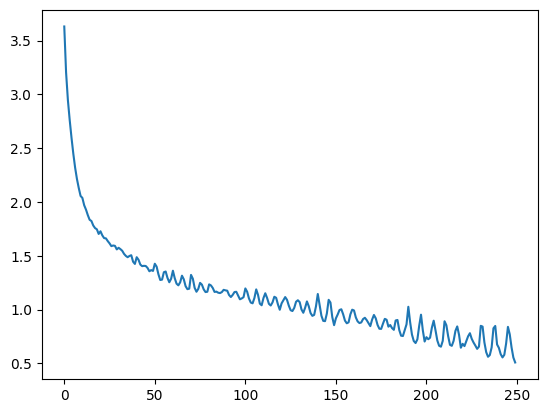

In [51]:
plt.plot(loss)

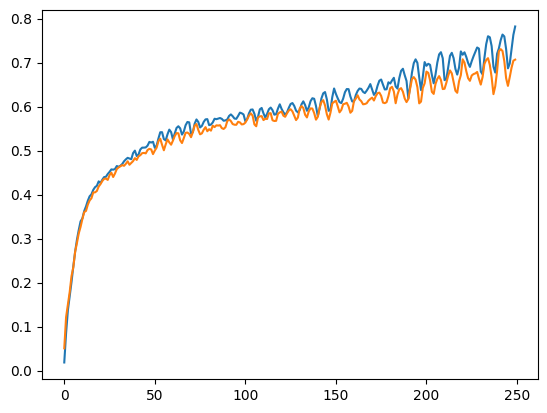

In [52]:
plt.plot(recall)
plt.plot(val_recall)

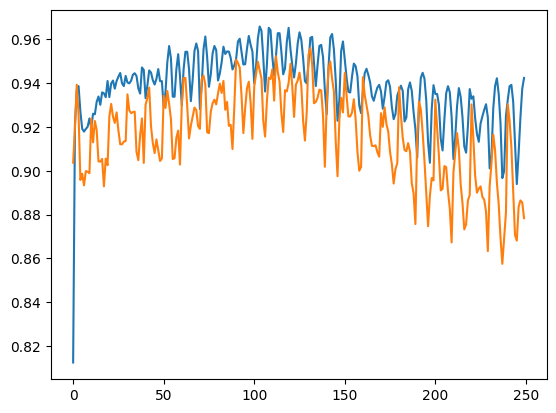

In [53]:
plt.plot(precision)
plt.plot(val_precision)

## Saving the model weight

In [32]:
model.save_weights("ModelWei_1")